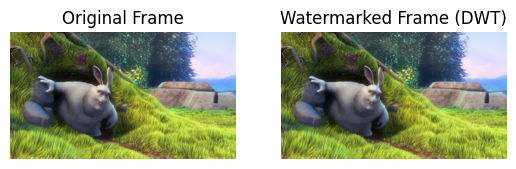

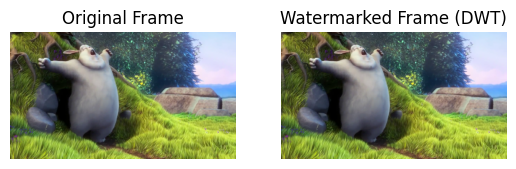

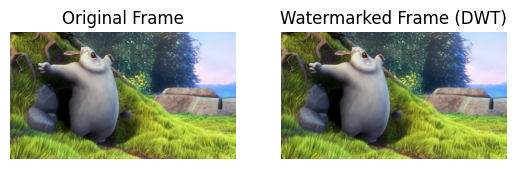

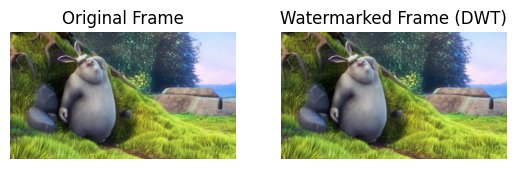

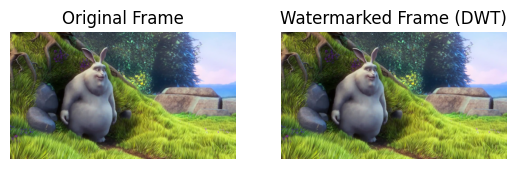

        PSNR      SSIM       MSE   NC   Entropy  Correlation  PTPF (sec)
0  78.114811  0.999999  0.001004  1.0  7.348727          1.0    0.430203
1  78.114811  0.999999  0.001004  1.0  7.492178          1.0    0.394065
2  78.114811  0.999998  0.001004  1.0  7.488111          1.0    0.285757
3  78.114811  0.999999  0.001004  1.0  7.447004          1.0    0.449991
4  78.114811  0.999999  0.001004  1.0  7.416808          1.0    0.416661


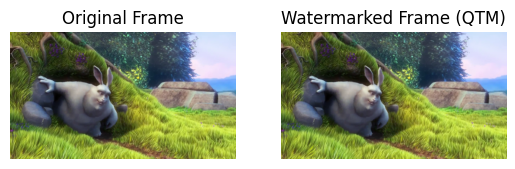

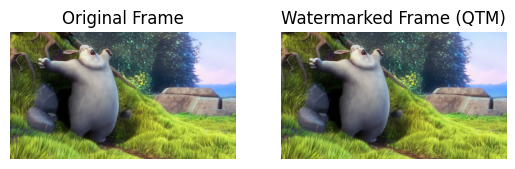

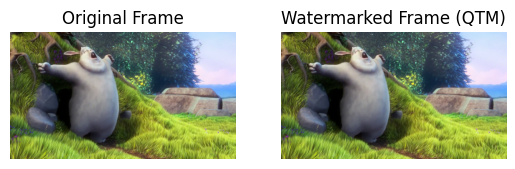

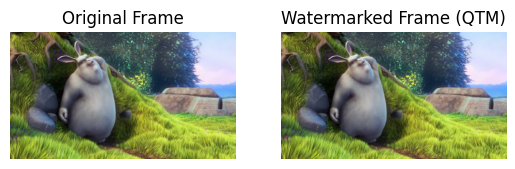

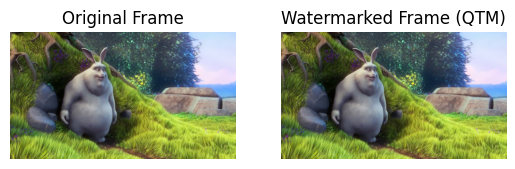

        PSNR  SSIM       MSE            NC   Entropy  Correlation  PTPF (sec)
0  92.335548   1.0  0.000038  1.007344e-09  7.348727          1.0    0.427052
1  92.419069   1.0  0.000037  1.360979e-09  7.492178          1.0    0.466863
2  92.335548   1.0  0.000038  3.612682e-09  7.488111          1.0    0.457115
3  92.335548   1.0  0.000038  2.052938e-09  7.447004          1.0    0.432688
4  92.335548   1.0  0.000038  5.154957e-10  7.416808          1.0    0.433215


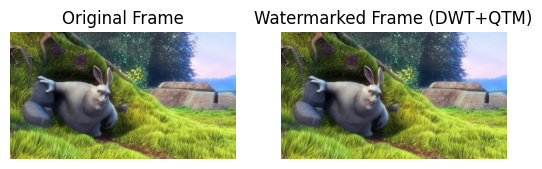

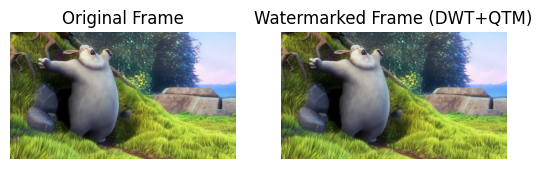

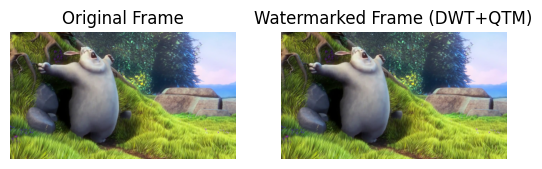

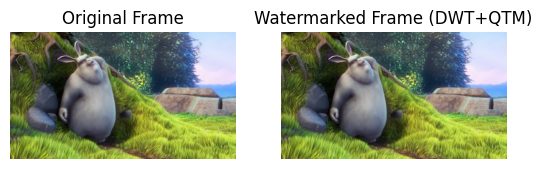

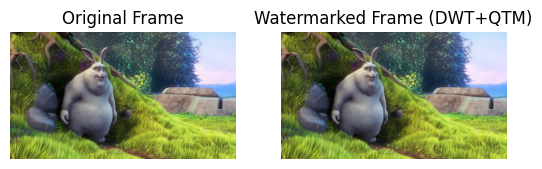

        PSNR      SSIM       MSE            NC   Entropy  Correlation  \
0  77.875801  0.999999  0.001060  4.830672e-09  7.348727          1.0   
1  77.926457  0.999998  0.001048  2.833514e-09  7.492178          1.0   
2  77.911497  0.999998  0.001052  1.570732e-10  7.488111          1.0   
3  77.910004  0.999998  0.001052  3.786530e-09  7.447004          1.0   
4  77.896588  0.999998  0.001055  2.085415e-09  7.416808          1.0   

   PTPF (sec)  
0    0.427163  
1    0.422677  
2    0.421606  
3    0.453624  
4    0.452047  


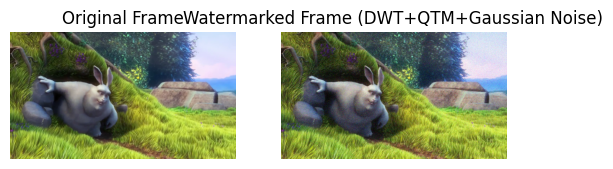

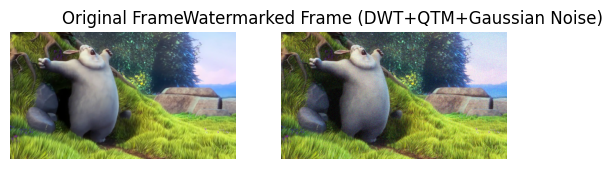

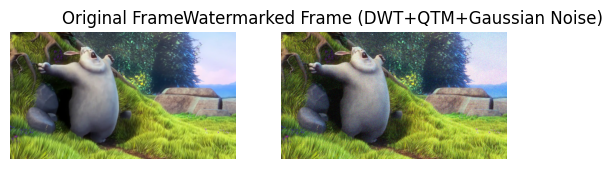

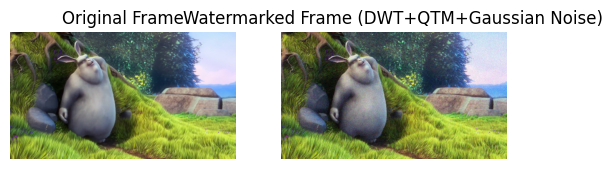

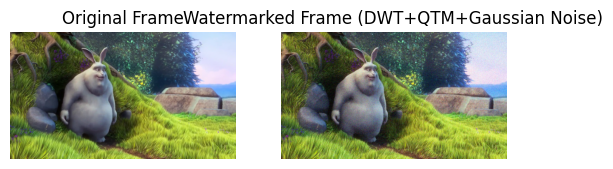

        PSNR      SSIM        MSE            NC   Entropy  Correlation  \
0  28.476371  0.305706  92.351359  1.042361e-09  7.348727     0.932580   
1  28.504241  0.280059  91.760606  3.644892e-09  7.492178     0.932807   
2  28.506037  0.285162  91.722664  1.843840e-09  7.488111     0.932674   
3  28.474907  0.294410  92.382496  5.531443e-09  7.447004     0.929696   
4  28.475953  0.299418  92.360251  1.390910e-09  7.416808     0.929489   

   PTPF (sec)  
0    0.313547  
1    0.411143  
2    0.234536  
3    0.411968  
4    0.431171  


In [1]:
import cv2
import numpy as np
import pywt
import random
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float
import math
import pandas as pd  # Import pandas for DataFrame
import time

# Function to apply Discrete Wavelet Transform (DWT) to a single channel
def apply_wavelet_transform(image_channel, wavelet_type='haar'):
    coeffs = pywt.dwt2(image_channel, wavelet_type)
    cA, (cH, cV, cD) = coeffs
    return cA, cH, cV, cD

# Function to perform inverse DWT for a single channel
def inverse_wavelet_transform(cA, cH, cV, cD, wavelet_type='haar'):
    return pywt.idwt2((cA, (cH, cV, cD)), wavelet_type)

# Function to embed watermark using DWT in a single channel
def embed_watermark_channel(channel, watermark_text):
    cA, cH, cV, cD = apply_wavelet_transform(channel)
    binary_watermark = ''.join(format(ord(c), '08b') for c in watermark_text)
    key_index = 0
    for i in range(cH.shape[0]):
        for j in range(cH.shape[1]):
            if key_index < len(binary_watermark):
                cH[i, j] += int(binary_watermark[key_index]) * 5  # Embed watermark in the horizontal detail coefficients
                key_index += 1
    watermarked_channel = inverse_wavelet_transform(cA, cH, cV, cD)
    return watermarked_channel

# Function to embed watermark in a color image using DWT
def embed_watermark_color_image_dwt(image, watermark_text):
    (B, G, R) = cv2.split(image)
    R_watermarked = embed_watermark_channel(R, watermark_text)
    G_watermarked = embed_watermark_channel(G, watermark_text)
    B_watermarked = embed_watermark_channel(B, watermark_text)
    return cv2.merge([B_watermarked, G_watermarked, R_watermarked])

# Function to embed watermark using QTM (Quantization-based Watermarking)
def embed_watermark_qtm(image, watermark_text, qtm_factor):
    image_float = image.astype(np.float32)
    binary_watermark = ''.join(format(ord(c), '08b') for c in watermark_text)
    key_index = 0

    for i in range(image_float.shape[0]):
        for j in range(image_float.shape[1]):
            if key_index < len(binary_watermark):
                pixel_value = image_float[i, j]
                if binary_watermark[key_index] == '1':
                    image_float[i, j] = pixel_value + qtm_factor
                else:
                    image_float[i, j] = pixel_value - qtm_factor
                key_index += 1
    return np.uint8(np.clip(image_float, 0, 255))

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean=0, sigma=25):
    gaussian_noise = np.random.normal(mean, sigma, image.shape).astype(np.float32)
    image_float = image.astype(np.float32)
    noisy_image = image_float + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

# Metric Calculations

# PSNR (Peak Signal to Noise Ratio)
def psnr(original, watermarked):
    mse_value = np.mean((original - watermarked) ** 2)
    return 10 * np.log10(255 ** 2 / mse_value) if mse_value != 0 else float('inf')

# SSIM (Structural Similarity Index)
def ssim_index(original, watermarked):
    return ssim(original, watermarked, channel_axis=-1, data_range=255)

# MSE (Mean Squared Error)
def mse(original, watermarked):
    return np.mean((original - watermarked) ** 2)

# NC (Normalized Correlation)
def normalized_correlation(original, watermarked):
    original = original.flatten()
    watermarked = watermarked.flatten()
    return np.dot(original, watermarked) / (np.linalg.norm(original) * np.linalg.norm(watermarked))

# Entropy of the Image
def entropy(image):
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    histogram = histogram / histogram.sum()
    return -np.sum(histogram * np.log2(histogram + 1e-10))

# Correlation Coefficient
def correlation_coefficient(original, watermarked):
    return np.corrcoef(original.flatten(), watermarked.flatten())[0, 1]

# PTPF (Processing Time Per Frame)
def ptpf(func, *args):
    start_time = time.time()
    func(*args)
    return time.time() - start_time

# Function to process video and calculate metrics
def process_video(input_video_path, watermark_text="Watermark", qtm_factor=5, algorithm="DWT+QTM+Gaussian Noise"):
    cap = cv2.VideoCapture(input_video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    selected_frames = [27, 76, 98, 121, 142]  # Use fixed selected frames

    metrics = []
    
    # Define the codec and create a VideoWriter object to save output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'
    output_video_path = f'output_{algorithm}.mp4'
    out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

    for frame_index in selected_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if not ret:
            continue
        
        if algorithm == "DWT":
            watermarked_frame = embed_watermark_color_image_dwt(frame, watermark_text)
        elif algorithm == "QTM":
            watermarked_frame = embed_watermark_qtm(frame, watermark_text, qtm_factor)
        elif algorithm == "DWT+QTM":
            watermarked_frame = embed_watermark_color_image_dwt(frame, watermark_text)
            watermarked_frame = embed_watermark_qtm(watermarked_frame, watermark_text, qtm_factor)
        elif algorithm == "DWT+QTM+Gaussian Noise":
            watermarked_frame = embed_watermark_color_image_dwt(frame, watermark_text)
            watermarked_frame = embed_watermark_qtm(watermarked_frame, watermark_text, qtm_factor)
            watermarked_frame = add_gaussian_noise(watermarked_frame)
        
        # Display original and watermarked frame
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title("Original Frame")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        # Ensure the watermarked frame is uint8 before color conversion
        watermarked_frame_uint8 = np.uint8(np.clip(watermarked_frame, 0, 255))
        plt.imshow(cv2.cvtColor(watermarked_frame_uint8, cv2.COLOR_BGR2RGB))
        plt.title(f"Watermarked Frame ({algorithm})")
        plt.axis('off')

        plt.show()

        # Calculate metrics
        psnr_value = psnr(frame, watermarked_frame)
        ssim_value = ssim_index(frame, watermarked_frame)
        mse_value = mse(frame, watermarked_frame)
        nc_value = normalized_correlation(frame, watermarked_frame)
        entropy_value = entropy(frame)
        correlation_value = correlation_coefficient(frame, watermarked_frame)
        ptpf_value = ptpf(embed_watermark_color_image_dwt, frame, watermark_text)

        metrics.append([psnr_value, ssim_value, mse_value, nc_value, entropy_value, correlation_value, ptpf_value])

        # Write the watermarked frame to the output video
        out.write(watermarked_frame)

    # Display metrics in a table
    metrics = np.array(metrics)
    columns = ["PSNR", "SSIM", "MSE", "NC", "Entropy", "Correlation", "PTPF (sec)"]
    df = pd.DataFrame(metrics, columns=columns)
    print(df)

    # Release resources
    cap.release()
    out.release()

# Example usage
input_video_path = 'input_video.mp4'
process_video(input_video_path, watermark_text="Watermark", algorithm="DWT")
process_video(input_video_path, watermark_text="Watermark", qtm_factor=0.25, algorithm="QTM")
process_video(input_video_path, watermark_text="Watermark", qtm_factor=0.25, algorithm="DWT+QTM")
process_video(input_video_path, watermark_text="Watermark", qtm_factor=0.25, algorithm="DWT+QTM+Gaussian Noise")
